## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
- Дополнительные услуги:
Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- personal_new.csv — персональные данные клиента;
- contract_new.csv — информация о договоре;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных и библиотек


In [1]:
!pip install scikit-learn==1.1.3

In [2]:
 !pip install phik

In [3]:
!pip install catboost

In [4]:
import pandas as pd
import matplotlib.pyplot as ppl
import phik
import numpy as np
import seaborn as sns
import datetime as dt
from math import *

from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV)
#from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
#from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler
)
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
RANDOM_STATE = 31084

In [6]:
personal = pd.read_csv('/content/personal_new (1).csv')

contract = pd.read_csv('/content/contract_new (1).csv')

internet = pd.read_csv('/content/internet_new (1).csv')

phone = pd.read_csv('/content/phone_new (1).csv')

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal.shape

(7043, 5)

In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [11]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [12]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

**Вывод по датасету personal:** Датасет содержит информацию о 7043 уникальных клиентах. Прочие данные содержат 2 типа значений, при обработке можно будет перевести их в булев формат или закодировать 1 и 0. По гендерному признаку в данных примерно по 50% мужчин и женщин. Пенсионеров около 1/7 всех клиентов.

### Датасет contract

In [13]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [14]:
contract.shape

(7043, 8)

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [16]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [17]:
contract['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

In [18]:
print('Количество закрытых договоров:', contract.loc[contract['EndDate'] != 'No', 'customerID'].count())
print('Количество действующих договоров:', contract.loc[contract['EndDate'] == 'No', 'customerID'].count())

Количество закрытых договоров: 1101
Количество действующих договоров: 5942


In [19]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

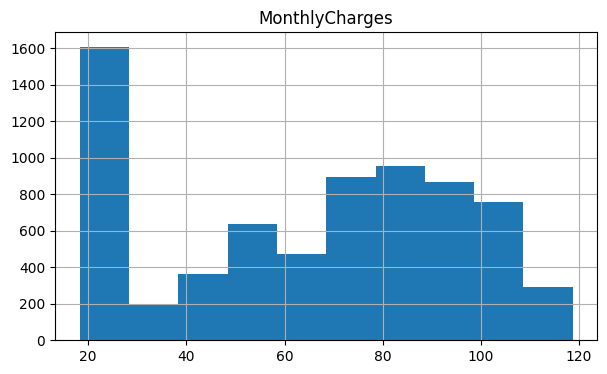

In [20]:
contract.hist(figsize=(7,4))
ppl.show()

**Вывод по датасету с контрактами** - Таблица содержит 7043 строк, данные по клиенту уникальны - номер клиента не дублируется. Данные из колонки PaperlessBilling скорее всего не понадобятся для машинного обучения. Колонка TotalCharges содержит данные типа object - их следует перевести в числовые на этапе предобработки. Из данных о заключении и расторжении контракта можно получить информацию о сроке сотрудничества с клиентом.
Большая часть пользователей предпочитает помесячную оплату. Медианная оплата от клиента составляет 70 долларов.

По действующим и закрытым договорам наблюдается дисбаланс классов - необходимо будет учесть это при разбиении на выборки.
Количество закрытых договоров: 1101
Количество действующих договоров: 5942

### Датасет internet

In [21]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [22]:
internet.shape

(5517, 8)

In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [25]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [26]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [27]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

**Вывод по датасету интернет** - Таблица содержит  5517 строк, данные по клиенту уникальны - номер клиента не дублируется. Датасет по размеру меньше, чем, содержащий данные о клиентах и контрактах - необходимо это учеть, для того, чтобы сохранить все данные для дальнийшего анализа.
Дополнительные услуги распределены в пропорции до 63% - серьезный дисбаланс классов отстутствует.

### Датасет phone

In [28]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [29]:
phone.shape

(6361, 2)

In [30]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [31]:
phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [32]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

**Вывод по датасету интернет** - Таблица содержит  6361 строк, данные по клиенту уникальны - номер клиента не дублируется. Датасет по размеру меньше, чем, содержащий данные о клиентах и контрактах - необходимо это учеть, для того, чтобы сохранить все данные для дальнийшего анализа.
Датасет содержит данные о том, пользуется ли клиент несколькими телефонными линиями.
Данные распределены в пропорции 47/63% - дисбаланс классов отстутствует.


## План работы

После знакомства с данными составила план дальнейшей работы:
1. Объединить таблицы, присоединив все таблицы к датасету с персональными данными клиентов, так как она сожержит максимально возможное число строк (как и датасет с контрактами)
2. Сделать предобработку:
+ заполнить пропуски данных, образовавшиеся при обьединении таблиц
+ из данных с датами получить срок сотрудничества с клиентом и целевой признак - уход клиента
+ изменить тип данных с обьектного на числовой в колонке TotalCharges
3. Проанализировать общий датасет, возможно удалить неинформативные колонки, провести анализ на мультиколлинеарность.
4. Попробовать для машинного обучения следующие модели:
+ Логистическую регрессию (как быстро обучающуюся и хорошо подходящую для задач бинарной классификации)
+ К-ближайших соседей (как простой и эффективный алгоритм, тем более что данные у нас не многомерные)
+ Бустинг (как наиболее перспективный по причине объединения множества слабых классификаторов) - LightGBM и CatBoost.
5. Разделить данные на тренировочную и тестовую выборки в пропорции 0.25
6. Для линейной модели провести масштабирование и кодирование признаков.
7. Провести анализ лучшей модели и проверку на тестовой выборке.
8. Провести исследование важности признаков лучшей модели, построить матрицу ошибок.

## Предобработка данных

### Объединение таблиц

Необходимо бъединить таблицы, присоединив все таблицы к датасету с персональными данными клиентов, так как она сожержит максимально возможное число строк (как и датасет с контрактами)

In [33]:
print('Размер таблицы personal', personal.shape)
print('Размер таблицы contract', contract.shape)
print('Размер таблицы internet', internet.shape)
print('Размер таблицы phone', phone.shape)

Размер таблицы personal (7043, 5)
Размер таблицы contract (7043, 8)
Размер таблицы internet (5517, 8)
Размер таблицы phone (6361, 2)


In [34]:
df = personal.merge(internet, how='left', on='customerID')
df = df.merge(contract, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

In [35]:
df.shape

(7043, 20)

In [36]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,NaN
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,No
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,No
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,NaN
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,No


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   InternetService   5517 non-null   object 
 6   OnlineSecurity    5517 non-null   object 
 7   OnlineBackup      5517 non-null   object 
 8   DeviceProtection  5517 non-null   object 
 9   TechSupport       5517 non-null   object 
 10  StreamingTV       5517 non-null   object 
 11  StreamingMovies   5517 non-null   object 
 12  BeginDate         7043 non-null   object 
 13  EndDate           7043 non-null   object 
 14  Type              7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [38]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines
count,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,7043,7043,7043,7043,7043,7043.000000,7043,6361
unique,7043,2,NaN,2,2,2,2,2,2,2,2,2,77,67,3,2,4,NaN,6658,2
top,7590-VHVEG,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,366,5942,3875,4171,2365,NaN,11,3390
mean,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


**Вывод**: После объединения получился датасет на 7043 строки (данные не были потеряны) и 20 колонок, имеются пропуски.

### Заполнение пропусков

#### Пропуски из датасета phone

Из датасета phone пропуски образовались в колонке MultipleLines. Так как это единственные данные полученные из этого датасета, можно предположить, что они являются важными для анализа потребительского поведения.
Приняла решение пропущенные значения заполнить заглушкой 'No line'.

In [39]:
df['MultipleLines'] = df['MultipleLines'].fillna('No line')
df['MultipleLines'].value_counts()

No         3390
Yes        2971
No line     682
Name: MultipleLines, dtype: int64

#### Пропуски из датасета internet

Из датасета Internet пропуски образовались в следующих колонках:
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies

Данные из этих колонок так же являются важными для анализа клиента, так как отображают, пользуется ли он дополнительными платными услугами, предлагаемыми провайдером. Необходимо проанализировать разброс значений в колонках.

In [40]:
col_internet = list(internet.columns)
col_internet.remove('customerID')
col_internet

['InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [41]:
for i in col_internet:
    print(i, df[i].value_counts(), sep='\n')
    print('')

InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64

StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



Я предположила, что корректно будет в колонку InternetService к типу подключения добавить значение No.

В остальных колонках можно заполнить пропуски значением No, указывающим, что данные клиенты так же не выбрали воспользоваться данными сервисами.

In [42]:
for i in col_internet:
    df[i] = df[i].fillna('No')

In [43]:
for i in col_internet:
    print(i, df[i].value_counts(), sep='\n')
    print('')

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

OnlineSecurity
No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64

OnlineBackup
No     4614
Yes    2429
Name: OnlineBackup, dtype: int64

DeviceProtection
No     4621
Yes    2422
Name: DeviceProtection, dtype: int64

TechSupport
No     4999
Yes    2044
Name: TechSupport, dtype: int64

StreamingTV
No     4336
Yes    2707
Name: StreamingTV, dtype: int64

StreamingMovies
No     4311
Yes    2732
Name: StreamingMovies, dtype: int64



In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  BeginDate         7043 non-null   object 
 13  EndDate           7043 non-null   object 
 14  Type              7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


**Вывод** все пропуски в данных заполнены

### Добавление столбцов

Из колонок с данными о дате начала и завершения контракта можно получить целевой признак - ушел ли клиент. Можно создать колонку с 1 - если клиент ушел и 0, если клиент продолжает сотрудничество.

In [45]:
df['Gone'] = df['EndDate']
df.loc[df['Gone'] != 'No', 'Gone'] = 1
df.loc[df['Gone'] == 'No', 'Gone'] = 0
df['Gone'] = df['Gone'].astype('int')
df['Gone'].value_counts()

0    5942
1    1101
Name: Gone, dtype: int64

Так же из колонок с данными о начале и конце сотрудничества можно получить данные о сроке сотрудничества с клиентом. С клиентами, продолжающими сотрудничество можно принять как дату окончания, дату, на которую данные актуальны - 01.02.2020.

In [46]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df[['EndDate', 'BeginDate']] = df[['EndDate', 'BeginDate']].apply(pd.to_datetime)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   InternetService   7043 non-null   object        
 6   OnlineSecurity    7043 non-null   object        
 7   OnlineBackup      7043 non-null   object        
 8   DeviceProtection  7043 non-null   object        
 9   TechSupport       7043 non-null   object        
 10  StreamingTV       7043 non-null   object        
 11  StreamingMovies   7043 non-null   object        
 12  BeginDate         7043 non-null   datetime64[ns]
 13  EndDate           7043 non-null   datetime64[ns]
 14  Type              7043 n

In [48]:
df['Term'] = (df['EndDate'] - df['BeginDate'])
df['Term'] = (df['Term']).dt.days

In [49]:
df['Term']

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: Term, Length: 7043, dtype: int64

После добавления новых колонок на основе данных о датах, столбцы с датами можно удалить.

In [50]:
df.drop(['EndDate','BeginDate'], axis=1, inplace = True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Type              7043 non-null   object 
 13  PaperlessBilling  7043 non-null   object 
 14  PaymentMethod     7043 non-null   object 
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   object 


### Обработка типов данных

Тип данных в колонке TotalCharges является обьектным, хотя колонка содержит численные данные. Поэтому я решила поменять его на float

In [52]:
df['TotalCharges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

In [53]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [54]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

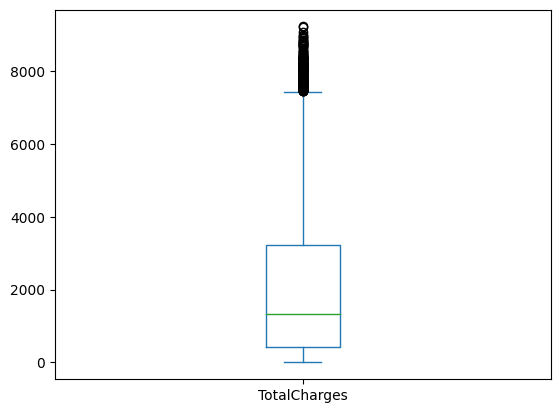

In [55]:
df['TotalCharges'].plot.box()
ppl.show()

Тип данных в колонке SeniorCitizen числовой, я думаю для единообразия данных логично его заменить на yes/no по аналогии с остальными колонками

In [56]:
df.loc[df['SeniorCitizen'] == '1', 'SeniorCitizen'] = 'Yes'
df.loc[df['SeniorCitizen'] == '0', 'SeniorCitizen'] = 'No'

### Анализ датасета для машинного обучения

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Type              7043 non-null   object 
 13  PaperlessBilling  7043 non-null   object 
 14  PaymentMethod     7043 non-null   object 
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [58]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,Gone,Term
count,7043,7043,7043.0,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043.000000,7043.000000
unique,7043,2,2.0,2,2,3,2,2,2,2,2,2,3,2,4,NaN,NaN,3,NaN,NaN
top,7590-VHVEG,Male,0.0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No,NaN,NaN
freq,1,3555,5901.0,3641,4933,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365,NaN,NaN,3390,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885,NaN,0.156325,898.555729
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814,NaN,0.363189,683.130510
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,NaN,0.000000,276.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1343.350000,NaN,0.000000,761.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3236.690000,NaN,0.000000,1461.000000


**Вывод**: Получившийся датасет состоит из 20 колонок, большинство из которых содержат бинарные данные. Для обучения модели необходимо удалить колонку customerID, так же я думаю что данные по PaperlessBilling не будут способствовать машинному обучению

In [59]:
df.drop(['customerID','PaperlessBilling'], axis=1, inplace = True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Type              7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   float64
 15  MultipleLines     7043 non-null   object 
 16  Gone              7043 non-null   int64  


**Вывод**: портрет клиента готов, необходимо дополнительно проанализировать признаки на мультиколленеарность

### Исследовательский анализ

Необходимо провести анализ данных на мультиколлинеарность и рассмотреть необходимость наличия отдельных признаков

In [61]:
phik = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Gone', 'Term']


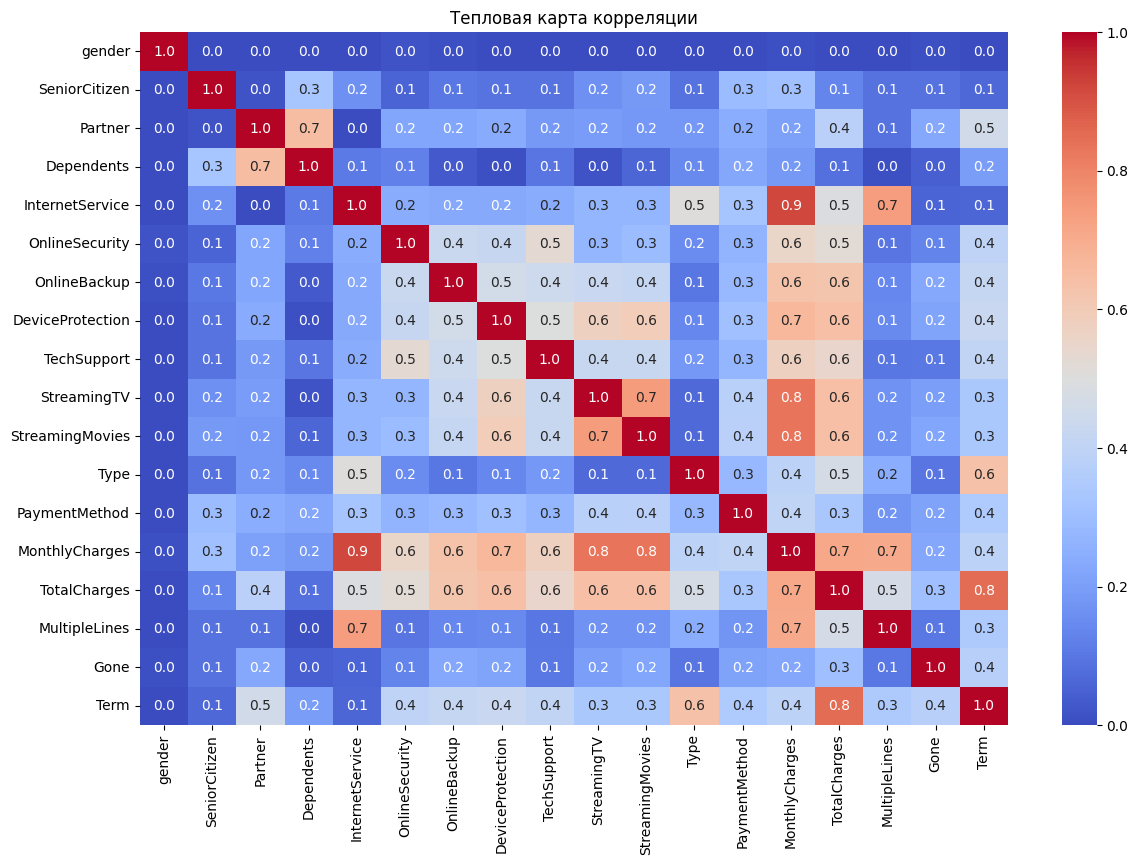

In [62]:
fig, ax = plt.subplots(figsize = (14,9))
ax = sns.heatmap(phik, annot=True, fmt=".1f", cmap= 'coolwarm')
plt.title("Тепловая карта корреляции")
plt.show()

При проверке на мультиколленеарность наблюдается зависимость более 0,8 наблюдается между TotalCharges и сроком сотрудничества с клиентом, что представляется абсолютно логичным. Чем долше клиент в компании, тем больше он заплатит. Колонку TotalCharges решила удалить.

Так же наблюдается сильная корреляция между MonthlyCharges и набором опций - InternetService, StreamingTV, StreamingMovies. Эти опции стоит рассмотреть относительно распределения ушедших и оставшихся клиентов.

In [63]:
cat_features = df.select_dtypes(include='object').columns.to_list()

In [64]:
def features_target_hist(data, features, target):
#Функция для построения графиков, отображающих распределение признаков относительно целевого признака.

    number_cols = 2
    n_rows = ceil(len(features) / number_cols)

    fig, axes = plt.subplots(n_rows, number_cols, figsize=(14, 3 * n_rows))
    axes = axes.flatten()

    # Создаем графики для каждого признака
    for i, feature in enumerate(features):
        ax = axes[i]

        # Группируем данные по признаку и целевому признаку, считаем количество записей
        df_group = data.groupby([feature, target])[target].count().nlargest(10)
        df_group = df_group.unstack()

        # Строим столбчатую диаграмму для каждого значения целевого признака
        for column in df_group.columns:
            ax.bar(df_group.index, df_group[column], alpha=0.4, label=column)

        # Настройка графика
        ax.set_xlabel('0 - клиент остался, 1 - клиент ушел')
        ax.set_ylabel('Количество')
        ax.legend()
        ax.set_title(f'Распределение {feature} относительно target', size=10)

    # Удаляем лишние пустые графики
    if len(features) < len(axes):
        for j in range(len(features), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

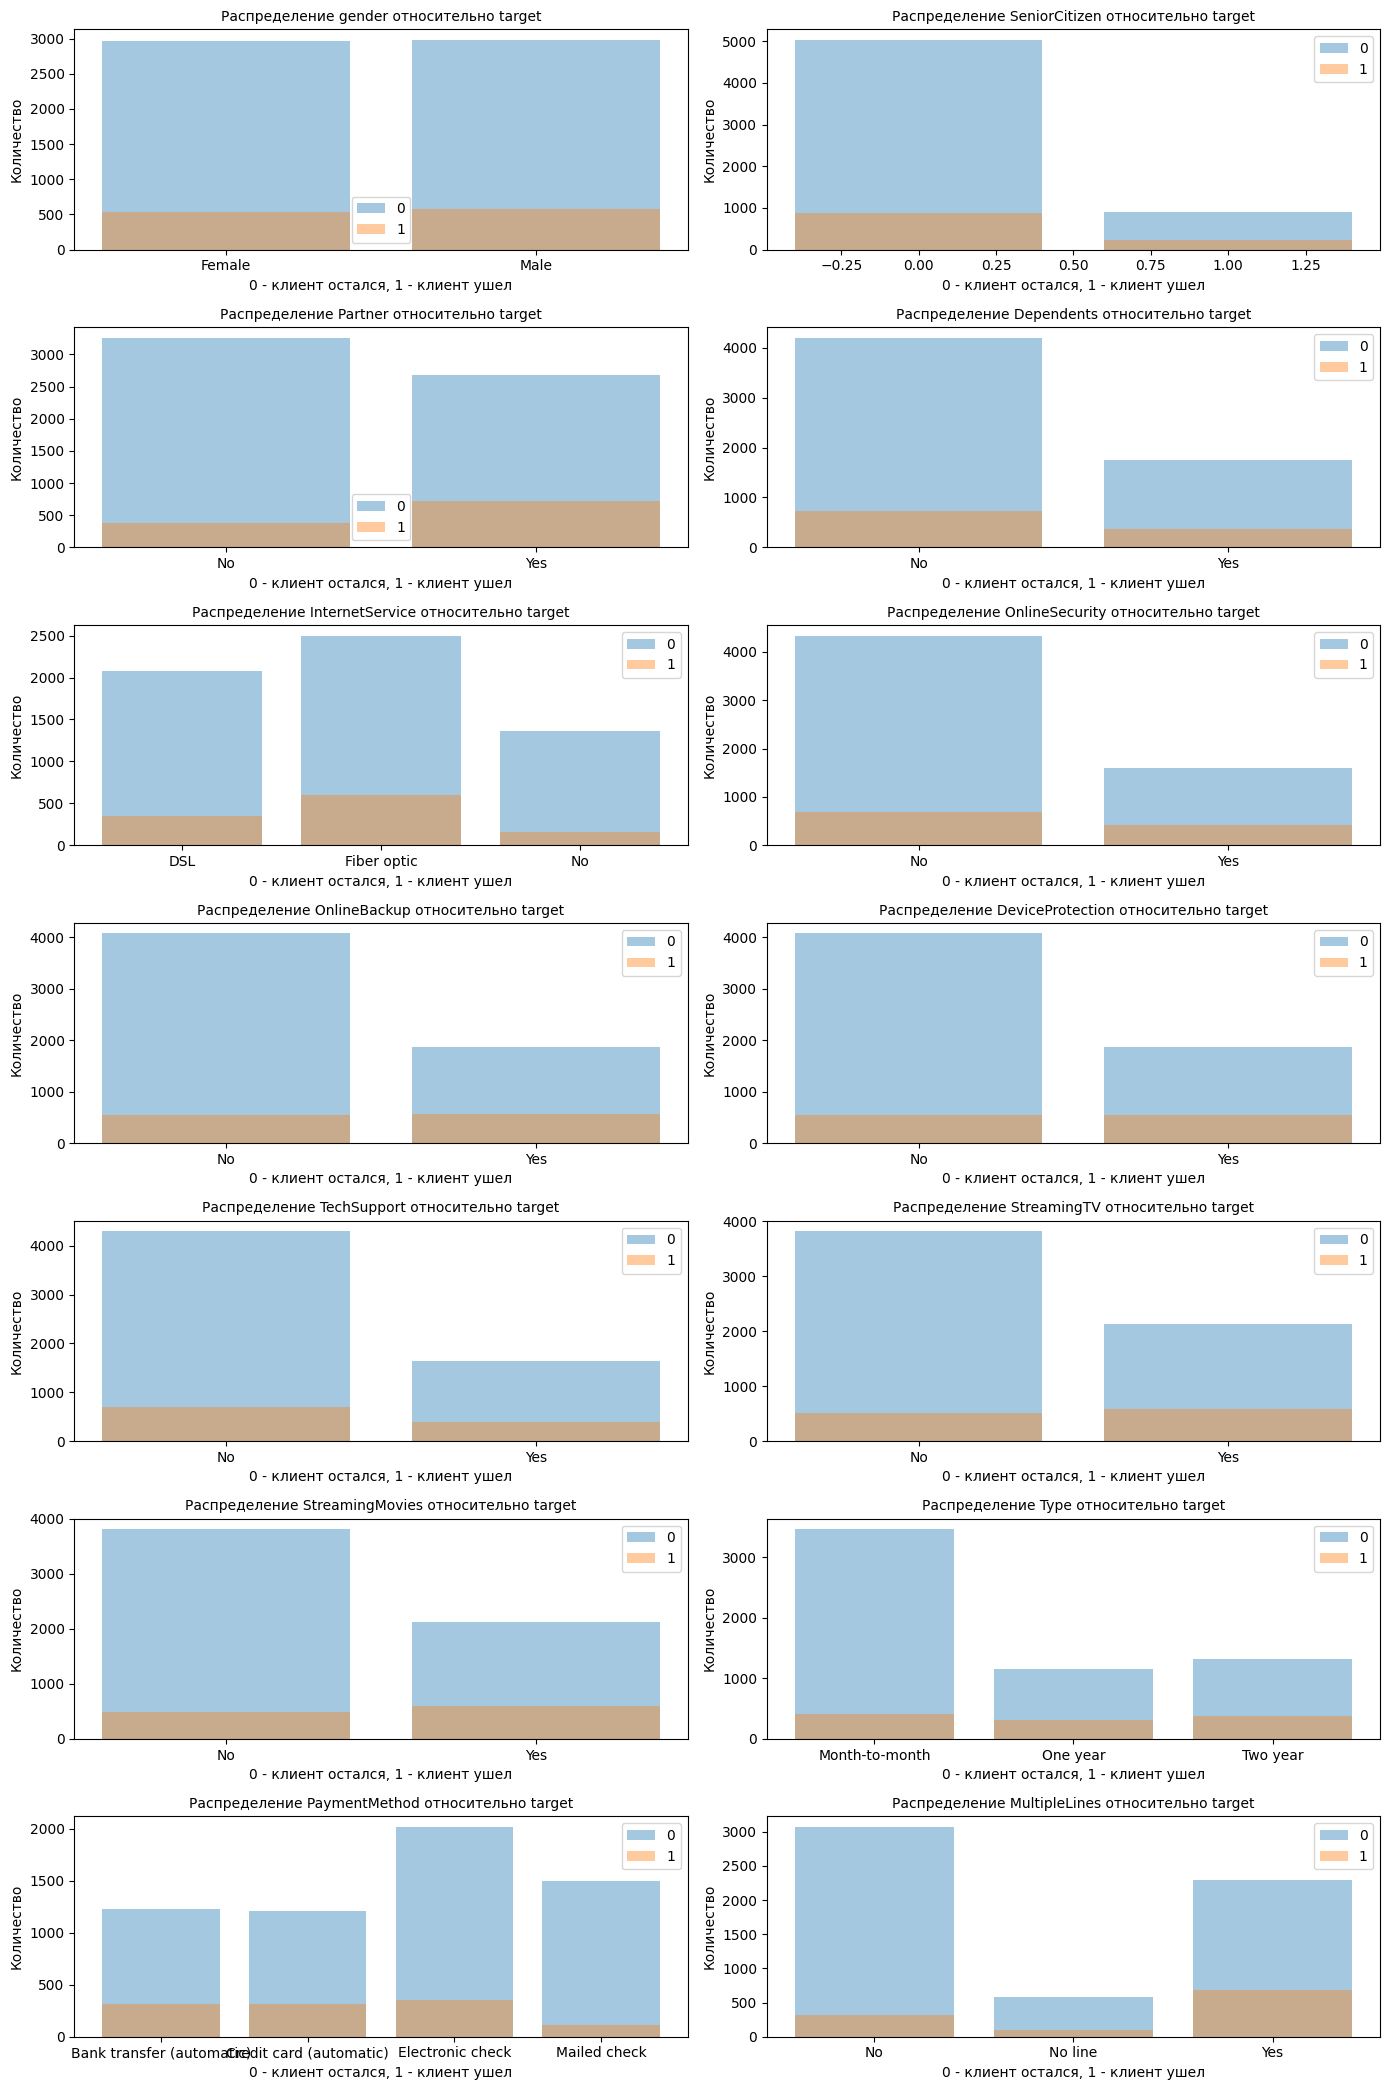

In [65]:
features_target_hist(df, cat_features, 'Gone')

На распределении признаков можно увидеть, что среди тех кто ушел и остался клиенты по полу(gender) распределены равномерно, соответственно эти данные можно удалить, так как они не окажут влияние на предсказание модели

Cильно коррелирующие с MonthlyCharges опции - StreamingTV и StreamingMovies активированны у небольшого количества пользователей, и, хотя среди активировавших, пропорционально большее число клиентов разоврало контракт, эти данные вряд ли окажут влияние на обучение модели

In [66]:
df = df.drop(['gender', 'TotalCharges'] , axis=1)
df.shape

(7043, 16)

**Вывод:** По итогам исследовательсткого анализа приняла решение удалить колонки gender, как не оказывающее влияния обучение модели и из признаков удалить TotalCharges, как имеющий сильную корреляцию.

### Подготовка выборок для машинного обучения

In [67]:
target = df['Gone']
features = df.drop(['Gone'] , axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [68]:
features_train.shape

(5282, 15)

In [69]:
features_test.shape

(1761, 15)

### Подготовка признаков для линейной модели

In [70]:
features_train_scaled = features_train.copy()

In [71]:
ohe_features = features_train_scaled.select_dtypes(include='object').columns.to_list()
ohe_features

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type',
 'PaymentMethod',
 'MultipleLines']

In [72]:
encoder_ohe = OneHotEncoder(drop='first', sparse=False)
encoder_ohe.fit(features_train_scaled[ohe_features])

# добавление закодированных признаков
features_train_scaled[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_scaled[ohe_features])

# удаление незакодированных изначальных колонок
features_train_scaled = features_train_scaled.drop(ohe_features, axis=1)

In [73]:
features_train_scaled.head()

,MonthlyCharges,Term,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No line,MultipleLines_Yes
6432,61.00,1067,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2234,59.70,702,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6071,105.55,2191,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4349,80.30,123,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2155,85.00,1006,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [74]:
features_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6432 to 4035
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5282 non-null   float64
 1   Term                                   5282 non-null   int64  
 2   SeniorCitizen_1                        5282 non-null   float64
 3   Partner_Yes                            5282 non-null   float64
 4   Dependents_Yes                         5282 non-null   float64
 5   InternetService_Fiber optic            5282 non-null   float64
 6   InternetService_No                     5282 non-null   float64
 7   OnlineSecurity_Yes                     5282 non-null   float64
 8   OnlineBackup_Yes                       5282 non-null   float64
 9   DeviceProtection_Yes                   5282 non-null   float64
 10  TechSupport_Yes                        5282 non-null   float64
 11  S

Note: Для работы линейной модели необходимо так же выполнить масштабирование числовых признаков с помощью MinMaxScaler

In [75]:
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train_scaled)

## Обучение моделей

### Модель Логистическая регрессия

In [76]:
LGR = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)

In [77]:
%%time
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'C': [0.0001, 0.001, 0.01, 10, 0.0005]}
grid_lgr = GridSearchCV(LGR, parameters, cv=5, scoring='roc_auc')
grid_lgr.fit(features_train_scaled, target_train)

print(grid_lgr.best_estimator_)
print(grid_lgr.best_params_)
print(grid_lgr.best_score_)

LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, random_state=31084,
                   solver='sag')
{'C': 10, 'solver': 'sag'}
0.751294352625073
CPU times: user 6.67 s, sys: 3.95 s, total: 10.6 s
Wall time: 15.6 s


**Вывод:** Модель Логистической регрессии с параметрами C = 10 и solver = sag показала результат ROC AUC 0,75, что не является достаточно хорошим показателем

### Модель К-ближайших соседей

In [78]:
KNN = KNeighborsClassifier(n_jobs=-1)

In [79]:
parameters_KNN = {
    'n_neighbors': (1, 35, 5),
    'p': (1,2),
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'metric': ('minkowski', 'chebyshev')
}

search_KNN = RandomizedSearchCV(
    KNN,
    parameters_KNN,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    n_iter=10,
    random_state=RANDOM_STATE
)

In [80]:
%%time
search_KNN.fit(features_train_scaled, target_train)
print(search_KNN.best_estimator_)
print(search_KNN.best_params_)
print(search_KNN.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=35)
{'p': 2, 'n_neighbors': 35, 'metric': 'minkowski', 'algorithm': 'ball_tree'}
0.7509581499087041
CPU times: user 391 ms, sys: 60 ms, total: 451 ms
Wall time: 12.2 s


**Вывод**: Модель К-ближайших соседей с подобранными параметрами так же как и Логистическая регрессия показала результат ROC AUC 0,76, что не является достаточно хорошим показателем

### Модель LightGBM

In [81]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()

In [82]:
features_train[cat_features] = features_train[cat_features].astype('category')

In [83]:
%%time

parameters_grid_lgbm = {
    'n_estimators': range(80, 120, 10),
    'boosting_type': ['gbdt', 'dart']
}

lgbm = LGBMClassifier(random_state=RANDOM_STATE)

lgbm_grid_cv = GridSearchCV(
    lgbm,
    parameters_grid_lgbm,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs=-1
)

lgbm_grid_cv.fit(features_train, target_train, categorical_feature=cat_features)

print(f'Наилучшая ROC AUC: {round(lgbm_grid_cv.best_score_, 3)}')
print(f'Наилучшие параметры: {lgbm_grid_cv.best_params_}')

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
Наилучшая ROC AUC: 0.872
Наилучшие параметры: {'boosting_type': 'gbdt', 'n_estimators': 110}
CPU times: user 576 ms, sys: 52.1 ms, total: 628 ms
Wall time: 12.5 s


**Вывод:** Модель LightGBM с параметрами boosting_type = gbdt и n_estimators = 110 показала результат AUC ROC 0,89, что является хорошим результатом.

### Модель CatBoost

In [84]:
%%time

parameters_grid_cat = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10]
}
cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    eval_metric='AUC',
    iterations=200,
    logging_level='Silent')

cat_grid_cv = GridSearchCV(
    cat,
    parameters_grid_cat,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs=-1
)

cat_grid_cv.fit(features_train, target_train, cat_features=cat_features)

print(f'Наилучшая ROC AUC: {round(cat_grid_cv.best_score_, 3)}')
print(f'Наилучшие параметры: {cat_grid_cv.best_params_}')

Наилучшая ROC AUC: 0.869
Наилучшие параметры: {'depth': 6, 'learning_rate': 0.1}
CPU times: user 4.21 s, sys: 446 ms, total: 4.65 s
Wall time: 1min 22s


**Вывод:** Модель CatBoost на кросс-валидации с параметрами depth = 6 и learning_rate = 0.1 показала результат AUC ROC 0,88, что является хорошим результатом.

## Тестирование лучшей модели

В процессе обучения моделей были получены следующие результаты:
- Модель Логистической регрессии показала результат ROC AUC 0,75
- Модель К-ближайших соседей показала результат ROC AUC 0,76
- LightGBM показала результат AUC ROC 0,89
- Модель CatBoost показала результат AUC ROC 0,88

Наилучшие показатели у модели LightGBM с параметрами boosting_type = gbdt и n_estimators = 110. Выберу ее для анализа на тестовой выборке и дальнейшей работы

In [85]:
best_model = LGBMClassifier(
    random_state=RANDOM_STATE,
    scoring = 'roc_auc',
    boosting_type = 'gbdt',
    n_estimators = 110
)

In [86]:
best_model.fit(features_train, target_train, categorical_feature=cat_features)

[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412


LGBMClassifier(n_estimators=110, random_state=31084, scoring='roc_auc')

In [87]:
features_test[cat_features] = features_test[cat_features].astype('category')

In [88]:
# Предсказание на тестовой выборке
predictions = best_model.predict(features_test)
probabilities = best_model.predict_proba(features_test)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(target_test, probabilities)
accuracy = accuracy_score(target_test, predictions)

[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] Unknown parameter: scoring


In [89]:
print('Метрика AUC ROC для лучшей модели на тестовых данных:', roc_auc)
print('Метрика Accuracy для лучшей модели на тестовых данных:', accuracy)

Метрика AUC ROC для лучшей модели на тестовых данных: 0.9040890737795179
Метрика Accuracy для лучшей модели на тестовых данных: 0.8915388983532084


**Вывод:** Модель LightGBM с параметрами boosting_type = gbdt и n_estimators = 110 показала результат AUC ROC 0,90 и точность 0,90. Что является хорошим результатом. Необходимо проанализировать модель на матрице ошибок и по важности признаков.

## Анализ лучшей модели

In [90]:
cm = confusion_matrix(target_test, predictions)

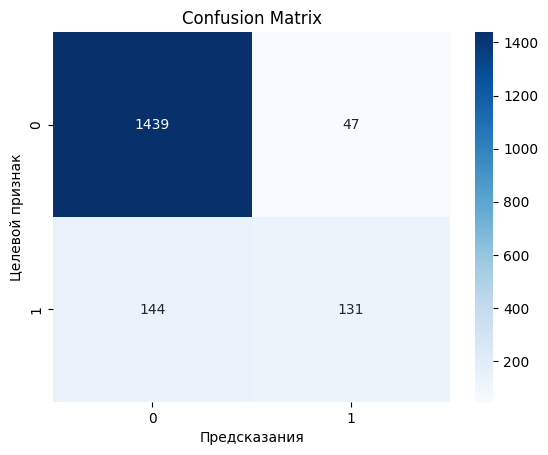

In [91]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

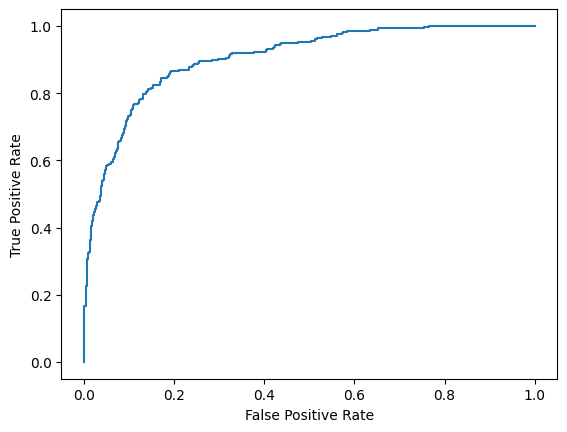

In [92]:
fpr, tpr, _ = roc_curve(target_test, probabilities)

plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Вывод:**
- Модель верно предсказала оставшихся клиентов (класс 0) - 1454 раз
- Модель ошибочно отнесла клиентов к оставшимся (класс 0) - 142 раза
- Модель верно предсказала ушедших клиентов (класс 1) - 133 раз
- Модель ошиблась в предсказании оставшихся клиентов (класс 1) - 32 раз

Таким образом, модель отнесла к оставшимя клиентам 1596 пользователей и ошиблась при этом в 9% случаев. К ушедшим пользователям модель отнесла 165 клиентов и ошиблась в 19% случаев.

ROC -кривая визуализировала качество модели. Высокое значение по оси Y говорит о большем количестве истинно положительных результатов по сравнению с ложноположительными ответами.

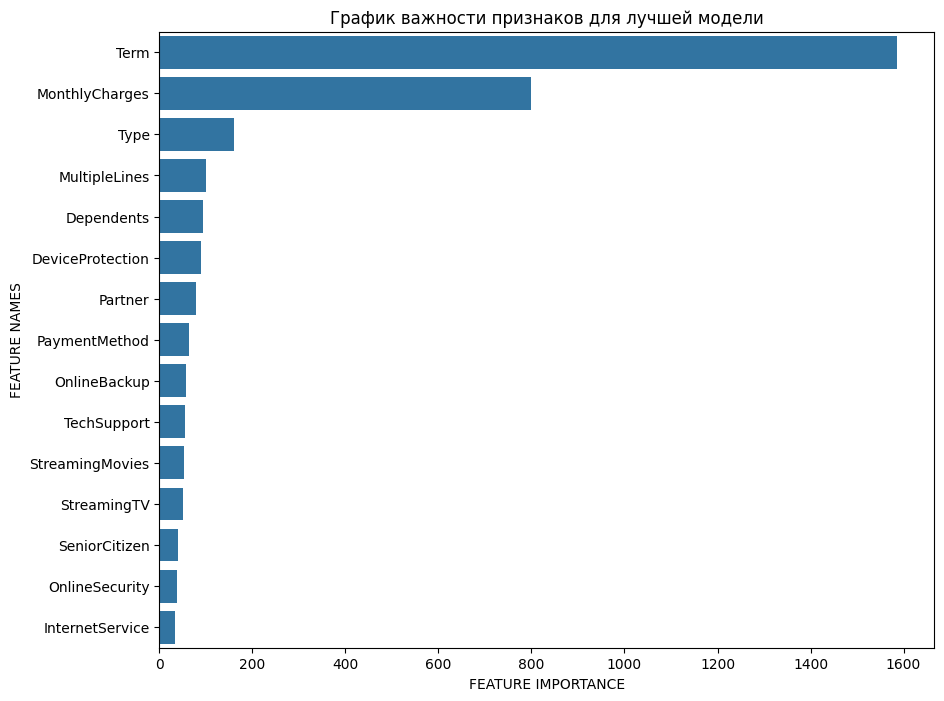

In [93]:
def plot_feature_importance(importance,names):

    #Создание массива данных из feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Создание датафрейма и сортировка значений
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Создание графика
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title('График важности признаков для лучшей модели')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')



plot_feature_importance(best_model.feature_importances_,features_train.columns)

**Вывод:** Из графика важности признаков видно, что самым ключевым для работы модели является срок содрудничества клиента с оператором. Следующими по важности c большим отрывом лидирует признак MonthlyCharges

## Выводы

**В процессе работы была проведена подготовка данных для дальнейшего обучения:**

1. Датасеты объединены в результате чего получился новый полный датасет на 7043 строки (данные не были потеряны) и 20 колонок.

2. Сделана предобработка - заполнены образовавшиеся в результате обьединения пропуски, обработаны типы данных

3. Был создан целевой признак из данных об окончании договора с клиентом. Так же, я приняла решение из колонок с датами сформировать новый признак - срок содрудничества клиента с оператором связи. С клиентами, продолжающими сотрудничество можно принять как дату окончания, дату, на которую данные актуальны - 01.02.2020.
4. Так же я провела проверку данных на мультиколленеарность и обнаружила, что наблюдается зависимость более 0,8 между TotalCharges и сроком сотрудничества с клиентом, что представляется абсолютно логичным. Чем дольше клиент в компании, тем больше он заплатит. Колонку TotalCharges решила удалить.

5. Кроме этого наблюдается сильная корреляция между MonthlyCharges и набором опций - InternetService, StreamingTV, StreamingMovies. Рассмотрев эти опции относительно распределения ушедших и оставшихся клиентов сделала вывод, что они активированны у небольшого количества пользователей, и, хотя среди активировавших, пропорционально большее число клиентов разоврало контракт, эти данные вряд ли окажут влияние на обучение модели

6. Так же проведя анализ распределения признаков обнаружила, что среди тех кто ушел и остался клиенты по полу(gender) распределены равномерно, соответственно эти данные можно удалить, так как они не окажут влияние на предсказание модели

**Для машинного обучения выбраны модели:**
- Модель Логистической регрессии
- Модель К-ближайших соседей
- LightGBM
- CatBoost

**При обучении модели показали следующие результаты:**
- Модель Логистической регрессии показала результат ROC AUC 0,75
- Модель К-ближайших соседей показала результат ROC AUC 0,76
- LightGBM показала результат AUC ROC 0,89
- Модель CatBoost показала результат AUC ROC 0,88

**Наилучшие показатели у модели LightGBM** с параметрами boosting_type = gbdt и n_estimators = 110. Выбрала ее для анализа на тестовой выборке и дальнейшей работы.

**Модель LightGBM на тестовой выборке показала результат AUC ROC 0,90 и точность 0,90.**

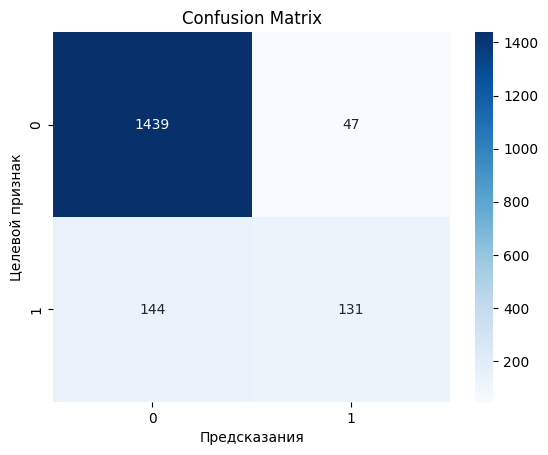

In [94]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

- Модель верно предсказала оставшихся клиентов (класс 0) - 1454 раз
- Модель ошибочно отнесла клиентов к оставшимся (класс 0) - 142 раза
- Модель верно предсказала ушедших клиентов (класс 1) - 133 раз
- Модель ошиблась в предсказании оставшихся клиентов (класс 1) - 32 раз

Таким образом, модель отнесла к оставшимя клиентам 1596 пользователей и ошиблась при этом в 9% случаев. К ушедшим пользователям модель отнесла 165 клиентов и ошиблась в 19% случаев.

**Для обучения модели были использованы следующие 15 признаков:**

In [95]:
features_train.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Type', 'PaymentMethod',
       'MonthlyCharges', 'MultipleLines', 'Term'],
      dtype='object')

На этапе предобработки в категориальных признаках были заполнены пропуски, единственный числовой признак был проанализирован на этапе знакомства с данными. Медианная сумма составляет 70 долларов, большинство клиентов платят около 20 долларов в месяц, выбросы отсутствуют.

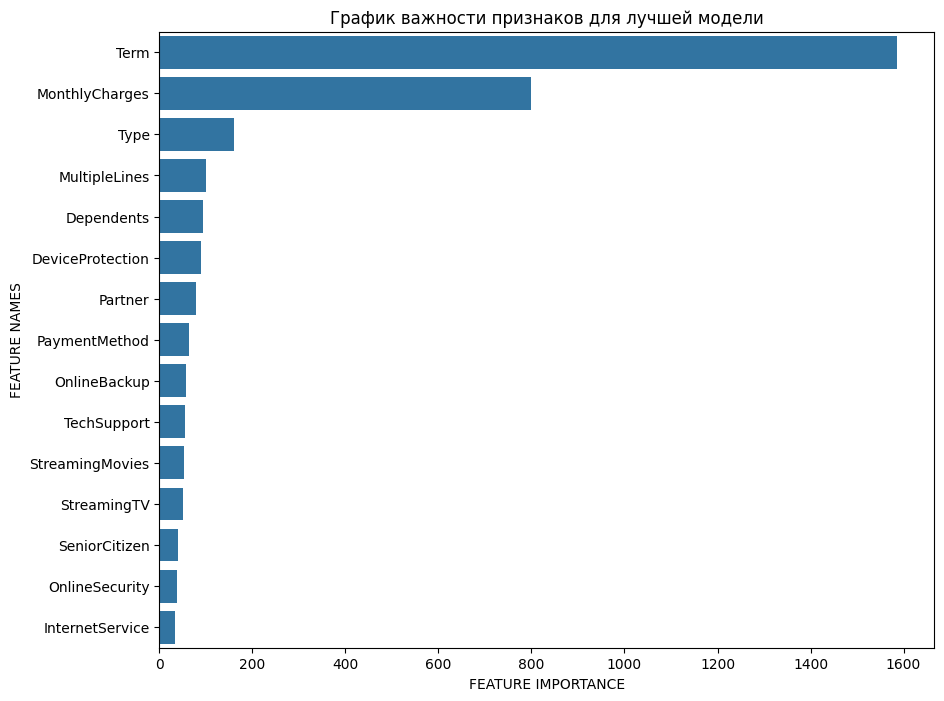

In [96]:
plot_feature_importance(best_model.feature_importances_,features_train.columns)

Из графика важности признаков видно, что самым ключевым для работы модели является срок содрудничества клиента с оператором. Следующими по важности c большим отрывом лидирует признак MonthlyCharges

**ИТОГ**

На основе собранных персональных данные о некоторых клиентах, информации об их тарифах и договорах была обучена Модель машинного обучения, которая с точностью 90% может предсказать, что пользователь планирует уйти.

На основе данных прогноза пользователю можно предложить промокоды и специальные условия, для того чтобы избежать расторжения контракта.

